# DEA Intertidal Elevation validation

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install -r requirements.in --quiet

In [ ]:
pip install xarray-spatial

In [2]:
%load_ext autoreload
%autoreload 2

import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox, Geometry
from dea_tools.datahandling import load_reproject
from dea_tools.dask import create_local_dask_cluster

from intertidal.validation import eval_metrics, map_raster, preprocess_validation

client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46209,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:43227,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/39187/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:42131,


## Validation sites from polygons

In [110]:
# Set up data paths
resampling="average"
resolution=10

# Load polygons
validation_sites_path = "data/raw/validation_sites_2021.geojson"
validation_sites_gdf = gpd.read_file(validation_sites_path)
validation_sites_gdf["mod_path"] = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
validation_sites_gdf["val_path"] = "/gdata1/projects/coastal/intertidal/Elevation_data/Processed/" + validation_sites_gdf.Year + "_combined.tif"
# validation_sites_gdf.loc[0, "mod_path"] = "data/processed/ga_s2ls_intertidal_cyear_3/0-0-1/x094/y145/2018--P1Y/ga_s2ls_intertidal_cyear_3_x094y145_2018--P1Y_final_elevation.tif"

# NIDEM comparison
# validation_sites_gdf["mod_path"] = "/gdata1/data/nidem/NIDEM_mosaic.tif"
# resampling="average"
# resolution=25



In [128]:
validation_zs = []
modelled_zs = []

for i, row in validation_sites_gdf.iterrows():
    print(i)

    # Convert to Geometry and create GeoBox to load data into
    poly = Geometry(row.geometry, crs="EPSG:4326")
    poly_geobox = odc.geo.geobox.GeoBox.from_geopolygon(
        poly, crs="EPSG:3577", resolution=resolution
    )

    # Load validation and modelled data into polygon GeoBox
    modelled_ds = load_reproject(
        path=row.mod_path, how=poly_geobox, resampling=resampling
    ).compute()
    validation_ds = load_reproject(
        path=row.val_path, how=poly_geobox, resampling=resampling
    ).compute()
    
    # Mask our data by our input polygon
    modelled_ds = modelled_ds.odc.mask(poly=poly)

    # Preprocess
    validation_z, modelled_z = preprocess_validation(modelled_ds, validation_ds)

    validation_zs.append(validation_z)
    modelled_zs.append(modelled_z)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Correlation         0.837
RMSE                0.264
MAE                 0.203
R-squared           0.700
Bias                0.167
Regression slope    0.850
dtype: float64
132.57479999999998 km sq


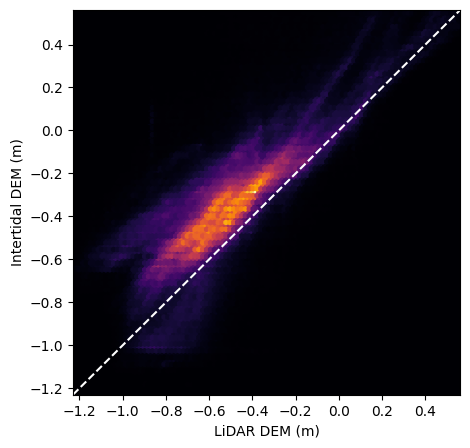

In [139]:
validation_all = np.concatenate(validation_zs)
modelled_all = np.concatenate(modelled_zs)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([validation_all, modelled_all]), [1, 95]
)
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_all,
    y=modelled_all,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=validation_all, y=modelled_all, round=3))
print(f"{len(modelled_all) * (10 * 10) * 0.000001} km sq")

## Individual validations

#### NT LiDAR

In [ ]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Load LIDAR validation data
validation_ds = (
    rioxarray.open_rasterio(val_path, masked=True)
    .squeeze("band")
    .sel(x=slice(623294, 720470), y=slice(8275633, 8214379))
)
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

#### Testing tiles

In [ ]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path1 = f"data/interim/x99y118/2019-2021/x99y118_2019_2021_elevation.tif"
mod_path2 = f"data/interim/x98y118/2019-2021/x98y118_2019_2021_elevation.tif"
mod_path3 = f"data/interim/x100y117/2019-2021/x100y117_2019_2021_elevation.tif"
mod_path4 = f"data/interim/x99y117/2019-2021/x99y117_2019_2021_elevation.tif"
# mod_path1 = f"data/interim/x99y118/2019-2021-spearman/x99y118_2019_2021_elevation_uncertainty.tif"
# mod_path2 = f"data/interim/x98y118/2019-2021-spearman/x98y118_2019_2021_elevation_uncertainty.tif"
# mod_path3 = f"data/interim/x100y117/2019-2021-spearman/x100y117_2019_2021_elevation_uncertainty.tif"
# mod_path4 = f"data/interim/x99y117/2019-2021-spearman/x99y117_2019_2021_elevation_uncertainty.tif"
resampling = "average"

# Load LIDAR validation data
validation_ds = (
    rioxarray.open_rasterio(val_path, masked=True)
    .squeeze("band")
    .sel(x=slice(623294, 720470), y=slice(8275633, 8214379))
)
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds1 = load_reproject(
    path=mod_path1,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds2 = load_reproject(
    path=mod_path2,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds3 = load_reproject(
    path=mod_path3,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds4 = load_reproject(
    path=mod_path4,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds = (
    modelled_ds1.combine_first(modelled_ds2)
    .combine_first(modelled_ds3)
    .combine_first(modelled_ds4)
)

In [ ]:
# modelled_ds.plot.imshow()

#### Moreton Bay SDB

In [ ]:
# Setup
val_path = "data/raw/SDB_AUS_MoretonBay_EOMAP_20220808_20230414_3m_MSL_geotiff.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Set geobox for specific bounding box
bbox = BoundingBox(2050863, -3186980, 2091372, -3070780, crs="EPSG:3577")
bbox = BoundingBox(2054949, -3158856, 2090075, -3130736, crs="EPSG:3577")
gbox = GeoBox.from_bbox(bbox, resolution=10)

# Load SDB as validation data
validation_ds = load_reproject(
    path=val_path, gbox=gbox, name="validation_ds", resampling=resampling
)

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

### Plot layers

In [ ]:
# Calculate difference
diff_ds = validation_ds - modelled_ds
diff_ds = diff_ds.odc.assign_crs(modelled_ds.odc.crs)
diff_ds.name = "difference"

# Plot both layers
map_raster(
    [validation_ds, modelled_ds, diff_ds],
    vmin=[-10.0, -10.0, -1.0],
    vmax=[0.5, 0.5, 1.0 ],
    cmap=["viridis", "viridis", "RdBu"],
)

#### Validate modelled elevation against validation elevation

In [ ]:
# Preprocess
validation_z, modelled_z = preprocess_validation(modelled_ds-0.18, validation_ds, None)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(np.concatenate([validation_z, modelled_z]), [1, 99])
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
eval_metrics(x=validation_z, y=modelled_z, round=3)

#### Compare elevation accuracy by uncertainty

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 10.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    
    # Extract subset of modelled elevation according to certainty range
    modelled_ds_subset = modelled_ds.where(
        (uncertainty_ds >= min_thresh) * (uncertainty_ds < max_thresh)
    )

    # Preprocess
    validation_z, modelled_z = preprocess_validation(
        modelled_ds_subset, validation_ds, None
    )

    # Compute accuracy metrics
    certainty_str = f"{min_thresh}-{max_thresh}"
    out[certainty_str] = eval_metrics(
        x=validation_z, y=modelled_z, round=3
    )
    
    # Plot heatmaps
    axes[i].hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(f"Certainty: {certainty_str} m")
    if i == 2:
        axes[i].set_xlabel("LiDAR DEM (m)")
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")

# Combine into a single dataframe
combined_df = pd.concat(out, axis=1)
combined_df.T.plot()
plt.gca().set_title("Accuracy statistics by certainty")
print(combined_df)